In [1]:
import tensorflow as tf
import os
import time
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from nilearn import image
from nilearn import plotting
import nibabel as nib
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
from nilearn.image import concat_imgs, mean_img
# import graph_nets as gn
# import sonnet as snt 
# from graph_nets import blocks
# from graph_nets import graphs
# from graph_nets import modules
# from graph_nets import utils_np
# from graph_nets import utils_tf
import seaborn as sns
import matplotlib.pylab as plt

Matplotlib created a temporary config/cache directory at /tmp/pbs.4050170.pbsha.ib.sockeye/matplotlib-68mj0bco because the default path (/home/mkhademi/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories


In [2]:
output_dir = '/scratch/st-ipor-1/mkhademi/'
subjs = ['CSI1', 'CSI2', 'CSI3', 'CSI4'] 
names = ['vehicle', 'animal', 'person', 'face', 'outdoor', 'sports', 'food', 'furniture', 'tool']
js = [91, 93, 0, 90, 92, 95, 97, 98, 102]
batch_size = 10
n_epochs = 60
def tf_parse(eg):
    example = tf.io.parse_example(
        eg, {
            'x': tf.io.FixedLenFeature(shape=(91, 109, 91, 1), dtype=tf.float32),
            'roi': tf.io.FixedLenFeature(shape=(16, 5085), dtype=tf.float32),
            'yhat': tf.io.FixedLenFeature(shape=(1000), dtype=tf.float32),
            'y_coco': tf.io.FixedLenFeature(shape=(90), dtype=tf.int64),
            'y_imagenet': tf.io.FixedLenFeature(shape=(1000), dtype=tf.int64),
            'y_super': tf.io.FixedLenFeature(shape=(12), dtype=tf.int64),
            'y_common': tf.io.FixedLenFeature(shape=(90+12+1), dtype=tf.int64)
        })
    return example['roi'], example['y_common']
def get_dataset(sub):
    dataset = tf.data.TFRecordDataset(
        filenames = [output_dir+'image_data/'+sub+'bold5000_common.tfrecords']).batch(batch_size)
    dataset = dataset.map(tf_parse)
    roi_names=['lFFA','rFFA','lOFA','rOFA','lSTS','rSTS','lLOC','rLOC','lPPA','rPPA','lRSC',
               'rRSC','lTOS','rTOS','lEBA','rEBA']
    return roi_names, dataset

In [3]:
def get_attn(dataset, j, n_epochs):
    train = dataset.map(lambda x, y: (x, tf.concat([y[:,j:j+1],
                        tf.ones_like(y[:,j:j+1],dtype=tf.int64)-y[:,j:j+1]],axis=1))) 
    inputs = tf.keras.Input(shape=(16, 5085))
    flt = tf.keras.layers.Flatten()
    inputs_flt = flt(inputs)
    dense = layers.Dense(16, activation=None)
    w = dense(inputs_flt)
    w = tf.reshape(w, [-1, 16, 1])
    
    w = tf.keras.layers.Softmax(axis=1, name='attn')(w)
    outputs = tf.repeat(w, 5085, axis=2) * inputs
    outputs = tf.math.reduce_sum(outputs, axis=1)
    outputs = tf.keras.layers.Dropout(rate=0.3)(outputs)
    #outputs = layers.Dense(64, activation='relu')(outputs)
    outputs = layers.Dense(2, activation=None)(outputs)
    outputs = tf.keras.layers.Softmax(axis=1)(outputs)
    model = keras.Model(inputs=inputs, outputs=outputs)
    # model.summary()
    model.compile(
        # loss='mse',
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        # loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
        # optimizer=keras.optimizers.RMSprop(),
        optimizer='adam',
        # metrics=[tf.keras.metrics.MeanSquaredError()],
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )
    model.fit(train, epochs=n_epochs) 
    layer_output = model.get_layer(name='attn').output
    attn = keras.Model(inputs=inputs, outputs=layer_output)
    return model, train, attn
def get_wts(train, attn, model):
    count = 0.0
    wts = np.zeros(16)
    for x, y in train:
        pred = model.predict(x)
        for j in range(y.shape[0]):
            if y[j][0] == 1 and pred[j][0] >= 0.5:
                count += 1
                tmp = attn.predict(x[j:j+1,:,:])[0][:,0]
                wts += np.copy(tmp)
    return wts/count

In [4]:
sub = subjs[0]
roi_names, dataset = get_dataset(sub)
all_wts = []
for idx, j in enumerate(js):
    model, train, attn = get_attn(dataset, j, n_epochs)
    print('************************************')
    print(names[idx])
    wts = get_wts(train, attn, model)
    print(wts)
    print('************************************')
    all_wts.append(wts)

2022-08-30 01:03:07.131274: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-08-30 01:03:07.189259: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:1c:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-30 01:03:07.193787: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-30 01:03:07.203308: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-30 01:03:07.209609: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-08-30 01:03:07.213433: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so

Epoch 1/60


2022-08-30 01:03:08.964973: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


287/287 [==============================] - 10s 34ms/step - loss: 0.5883 - categorical_accuracy: 0.7524
Epoch 2/60
287/287 [==============================] - 9s 31ms/step - loss: 0.4929 - categorical_accuracy: 0.8080
Epoch 3/60
287/287 [==============================] - 9s 30ms/step - loss: 0.4876 - categorical_accuracy: 0.8142
Epoch 4/60
287/287 [==============================] - 9s 30ms/step - loss: 0.4621 - categorical_accuracy: 0.8251
Epoch 5/60
287/287 [==============================] - 9s 30ms/step - loss: 0.4621 - categorical_accuracy: 0.8272
Epoch 6/60
287/287 [==============================] - 9s 30ms/step - loss: 0.4568 - categorical_accuracy: 0.8293
Epoch 7/60
287/287 [==============================] - 9s 30ms/step - loss: 0.4477 - categorical_accuracy: 0.8348
Epoch 8/60
287/287 [==============================] - 9s 30ms/step - loss: 0.4421 - categorical_accuracy: 0.8341
Epoch 9/60
287/287 [==============================] - 9s 30ms/step - loss: 0.4453 - categorical_accuracy: 

CSI1
[[0.621 0.015 0.174 0.008 0.015 0.008 0.015 0.008 0.    0.083 0.008 0.
  0.008 0.    0.008 0.03 ]
 [0.    0.    0.187 0.056 0.    0.    0.    0.    0.117 0.175 0.    0.418
  0.    0.006 0.018 0.023]
 [0.67  0.031 0.008 0.005 0.023 0.031 0.003 0.    0.008 0.213 0.    0.
  0.    0.002 0.    0.005]
 [0.    0.    0.    0.002 0.625 0.002 0.    0.    0.14  0.097 0.    0.024
  0.111 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.011 0.    0.    0.    0.    0.966
  0.    0.    0.023 0.   ]
 [0.213 0.005 0.021 0.005 0.    0.01  0.    0.    0.037 0.382 0.047 0.279
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.13  0.004 0.    0.    0.    0.    0.    0.866
  0.    0.    0.    0.   ]
 [0.116 0.047 0.    0.    0.558 0.023 0.    0.023 0.    0.047 0.    0.186
  0.    0.    0.    0.   ]
 [0.082 0.01  0.    0.    0.    0.    0.005 0.005 0.    0.016 0.    0.877
  0.    0.004 0.    0.   ]]


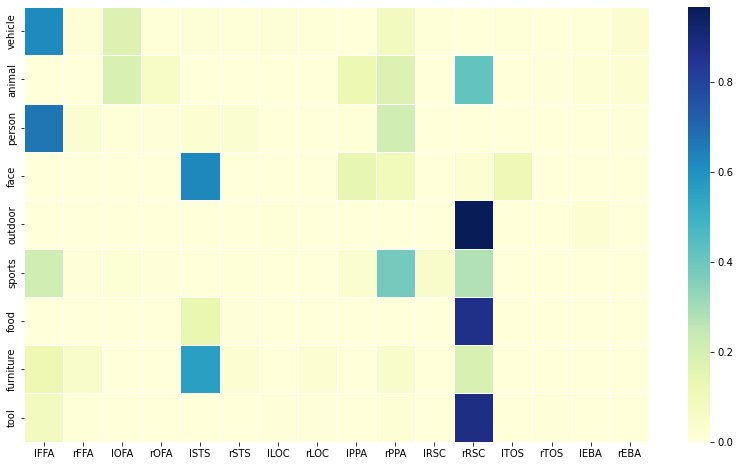

In [5]:
all_wts0 = all_wts
plt.rc('font', size=10)
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
all_wts = np.round(np.array(all_wts), decimals=3)
print(sub)
print(all_wts)
ax = sns.heatmap(all_wts, linewidth=0.5, cmap="YlGnBu")
ax.set_xticklabels(roi_names)
ax.set_yticklabels(names)
plt.show()

In [6]:
sub = subjs[1]
roi_names, dataset = get_dataset(sub)
all_wts = []
for idx, j in enumerate(js):
    model, train, attn = get_attn(dataset, j, n_epochs)
    print('************************************')
    print(names[idx])
    wts = get_wts(train, attn, model)
    print(wts)
    print('************************************')
    all_wts.append(wts)

Epoch 1/60
287/287 [==============================] - 10s 34ms/step - loss: 0.5451 - categorical_accuracy: 0.7926
Epoch 2/60
287/287 [==============================] - 9s 30ms/step - loss: 0.4643 - categorical_accuracy: 0.8111
Epoch 3/60
287/287 [==============================] - 8s 29ms/step - loss: 0.4484 - categorical_accuracy: 0.8191
Epoch 4/60
287/287 [==============================] - 8s 29ms/step - loss: 0.4578 - categorical_accuracy: 0.8097
Epoch 5/60
287/287 [==============================] - 8s 29ms/step - loss: 0.5014 - categorical_accuracy: 0.7867
Epoch 6/60
287/287 [==============================] - 8s 29ms/step - loss: 0.4541 - categorical_accuracy: 0.8170
Epoch 7/60
287/287 [==============================] - 8s 29ms/step - loss: 0.4398 - categorical_accuracy: 0.8230
Epoch 8/60
287/287 [==============================] - 8s 29ms/step - loss: 0.4429 - categorical_accuracy: 0.8191
Epoch 9/60
287/287 [==============================] - 8s 29ms/step - loss: 0.4511 - categorical

CSI2
[[0.005 0.    0.    0.    0.894 0.011 0.    0.    0.    0.058 0.011 0.021
  0.    0.    0.    0.   ]
 [0.899 0.    0.    0.    0.    0.    0.008 0.    0.    0.056 0.    0.
  0.02  0.    0.016 0.   ]
 [0.022 0.009 0.013 0.    0.035 0.043 0.017 0.    0.    0.    0.    0.004
  0.597 0.26  0.    0.   ]
 [0.    0.    0.    0.    0.211 0.    0.053 0.    0.    0.105 0.053 0.263
  0.211 0.    0.105 0.   ]
 [0.    0.012 0.    0.    0.904 0.    0.    0.    0.001 0.    0.    0.072
  0.    0.    0.    0.012]
 [0.    0.    0.024 0.    0.929 0.    0.008 0.    0.016 0.008 0.    0.008
  0.    0.    0.008 0.   ]
 [0.    0.    0.    0.    0.004 0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.996 0.   ]
 [0.    0.045 0.    0.    0.879 0.    0.    0.    0.03  0.    0.015 0.
  0.    0.    0.03  0.   ]
 [0.    0.    0.004 0.    0.    0.007 0.    0.007 0.    0.    0.018 0.953
  0.    0.    0.011 0.   ]]


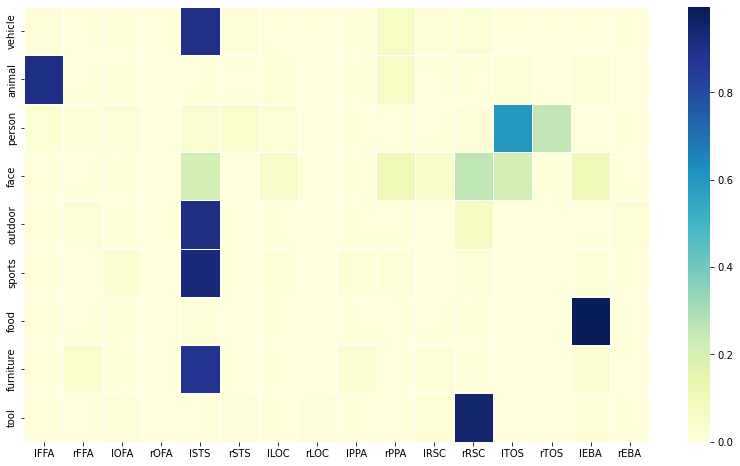

In [7]:
all_wts1 = all_wts
plt.rc('font', size=10)
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
all_wts = np.round(np.array(all_wts), decimals=3)
print(sub)
print(all_wts)
ax = sns.heatmap(all_wts, linewidth=0.5, cmap="YlGnBu")
ax.set_xticklabels(roi_names)
ax.set_yticklabels(names)
plt.show()

In [8]:
sub = subjs[2]
roi_names, dataset = get_dataset(sub)
all_wts = []
for idx, j in enumerate(js):
    model, train, attn = get_attn(dataset, j, n_epochs)
    print('************************************')
    print(names[idx])
    wts = get_wts(train, attn, model)
    print(wts)
    print('************************************')
    all_wts.append(wts)

Epoch 1/60
287/287 [==============================] - 10s 33ms/step - loss: 0.5778 - categorical_accuracy: 0.7795
Epoch 2/60
287/287 [==============================] - 9s 30ms/step - loss: 0.5189 - categorical_accuracy: 0.8047
Epoch 3/60
287/287 [==============================] - 8s 29ms/step - loss: 0.4561 - categorical_accuracy: 0.8190
Epoch 4/60
287/287 [==============================] - 8s 29ms/step - loss: 0.4482 - categorical_accuracy: 0.8211
Epoch 5/60
287/287 [==============================] - 8s 29ms/step - loss: 0.5750 - categorical_accuracy: 0.8270
Epoch 6/60
287/287 [==============================] - 8s 29ms/step - loss: 0.4274 - categorical_accuracy: 0.8319
Epoch 7/60
287/287 [==============================] - 8s 29ms/step - loss: 0.4218 - categorical_accuracy: 0.8295
Epoch 8/60
287/287 [==============================] - 8s 29ms/step - loss: 0.4268 - categorical_accuracy: 0.8298
Epoch 9/60
287/287 [==============================] - 8s 29ms/step - loss: 0.4127 - categorical

CSI3
[[0.    0.    0.006 0.    0.793 0.    0.    0.011 0.034 0.052 0.    0.092
  0.    0.    0.    0.011]
 [0.    0.015 0.    0.    0.    0.    0.03  0.    0.381 0.097 0.104 0.
  0.06  0.306 0.007 0.   ]
 [0.    0.    0.012 0.    0.625 0.017 0.002 0.    0.    0.07  0.044 0.
  0.225 0.006 0.    0.   ]
 [0.032 0.    0.069 0.    0.011 0.026 0.    0.005 0.    0.666 0.074 0.
  0.117 0.    0.    0.   ]
 [0.    0.    0.02  0.    0.36  0.    0.    0.    0.    0.05  0.02  0.51
  0.    0.    0.    0.04 ]
 [0.25  0.    0.022 0.    0.007 0.007 0.154 0.    0.522 0.007 0.    0.015
  0.    0.007 0.007 0.   ]
 [0.462 0.    0.    0.    0.    0.    0.077 0.154 0.    0.    0.    0.077
  0.    0.077 0.154 0.   ]
 [0.19  0.    0.    0.    0.    0.032 0.    0.    0.143 0.27  0.    0.19
  0.    0.    0.175 0.   ]
 [0.02  0.    0.031 0.    0.275 0.    0.02  0.    0.    0.163 0.    0.48
  0.    0.    0.    0.01 ]]


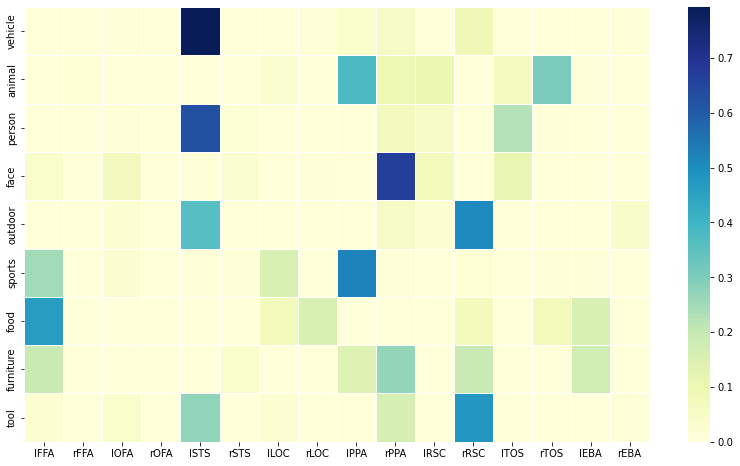

In [9]:
all_wts2 = all_wts
plt.rc('font', size=10)
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
all_wts = np.round(np.array(all_wts), decimals=3)
print(sub)
print(all_wts)
ax = sns.heatmap(all_wts, linewidth=0.5, cmap="YlGnBu")
ax.set_xticklabels(roi_names)
ax.set_yticklabels(names)
plt.show()

In [10]:
sub = subjs[3]
roi_names, dataset = get_dataset(sub)
all_wts = []
for idx, j in enumerate(js):
    model, train, attn = get_attn(dataset, j, n_epochs)
    print('************************************')
    print(names[idx])
    wts = get_wts(train, attn, model)
    print(wts)
    print('************************************')
    all_wts.append(wts)

Epoch 1/60
171/171 [==============================] - 5s 29ms/step - loss: 0.5473 - categorical_accuracy: 0.7825
Epoch 2/60
171/171 [==============================] - 5s 30ms/step - loss: 0.4675 - categorical_accuracy: 0.8213
Epoch 3/60
171/171 [==============================] - 5s 29ms/step - loss: 0.4731 - categorical_accuracy: 0.8319
Epoch 4/60
171/171 [==============================] - 5s 29ms/step - loss: 0.4509 - categorical_accuracy: 0.8401
Epoch 5/60
171/171 [==============================] - 5s 29ms/step - loss: 0.4401 - categorical_accuracy: 0.8430
Epoch 6/60
171/171 [==============================] - 5s 29ms/step - loss: 0.4343 - categorical_accuracy: 0.8424
Epoch 7/60
171/171 [==============================] - 5s 29ms/step - loss: 0.4390 - categorical_accuracy: 0.8436
Epoch 8/60
171/171 [==============================] - 5s 30ms/step - loss: 0.4315 - categorical_accuracy: 0.8448
Epoch 9/60
171/171 [==============================] - 5s 29ms/step - loss: 0.4331 - categorical_

CSI4
[[0.    0.143 0.    0.    0.571 0.    0.143 0.    0.    0.143 0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.005 0.    0.    0.    0.    0.    0.    0.966 0.    0.02
  0.    0.01  0.    0.   ]
 [0.    0.034 0.034 0.    0.    0.017 0.    0.017 0.    0.017 0.    0.017
  0.119 0.627 0.    0.119]
 [0.897 0.044 0.    0.    0.006 0.    0.006 0.    0.013 0.    0.    0.019
  0.008 0.    0.006 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.009 0.    0.    0.027 0.956
  0.009 0.    0.    0.   ]
 [0.012 0.    0.    0.    0.929 0.    0.    0.024 0.035 0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.983 0.    0.    0.    0.    0.    0.017 0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.5   0.    0.25  0.
  0.    0.    0.    0.25 ]
 [0.    0.    0.    0.    0.133 0.    0.    0.    0.    0.667 0.067 0.067
  0.067 0.    0.    0.   ]]


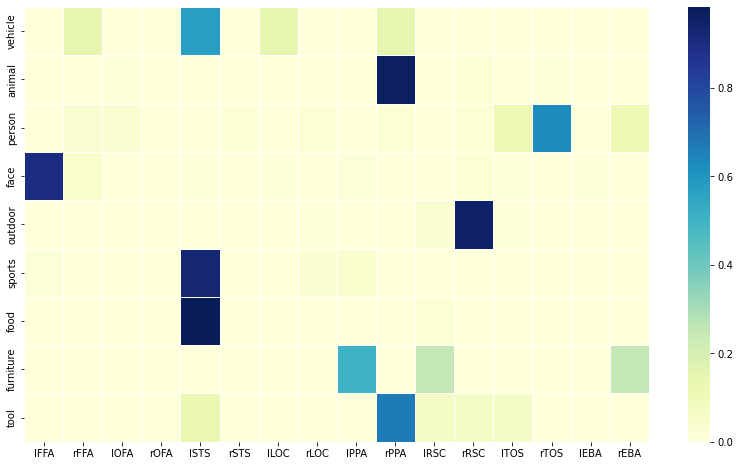

In [11]:
all_wts3 = all_wts
plt.rc('font', size=10)
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
all_wts = np.round(np.array(all_wts), decimals=3)
print(sub)
print(all_wts)
ax = sns.heatmap(all_wts, linewidth=0.5, cmap="YlGnBu")
ax.set_xticklabels(roi_names)
ax.set_yticklabels(names)
plt.show()

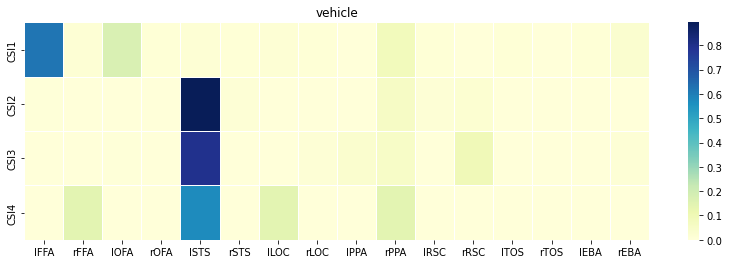

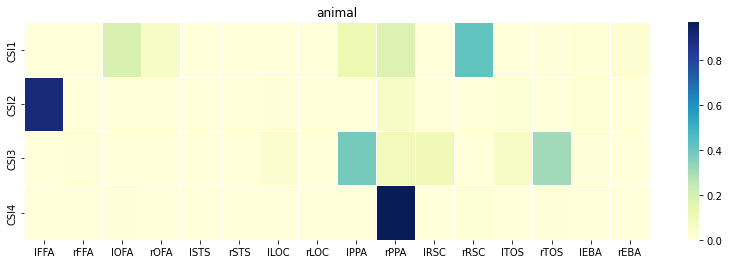

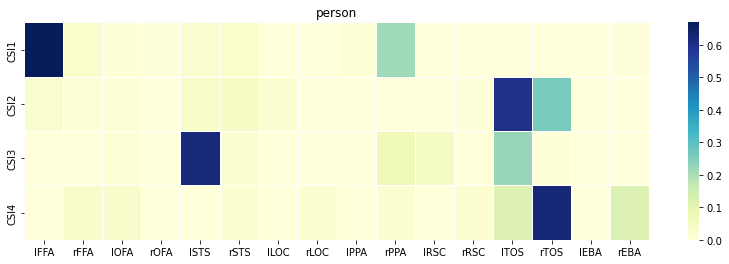

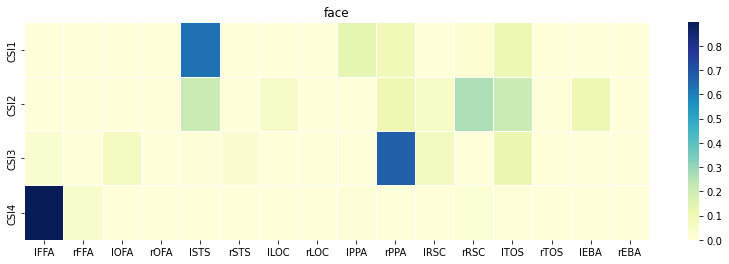

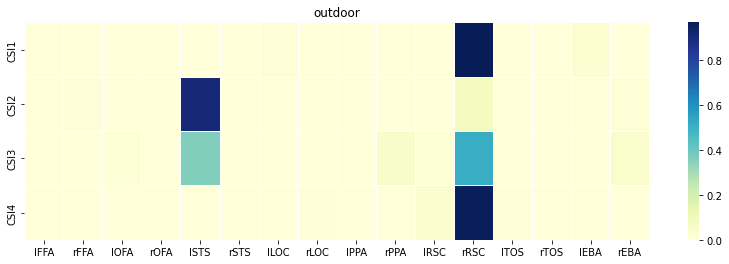

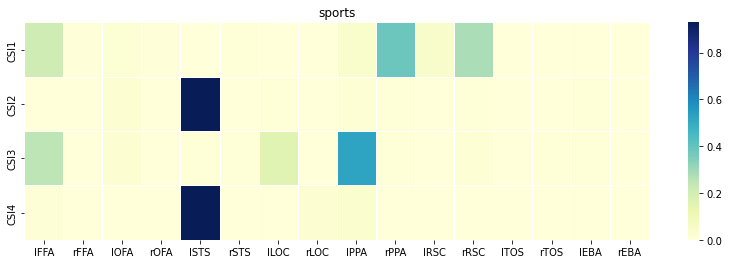

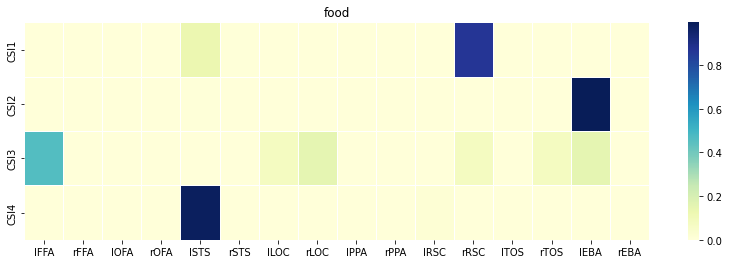

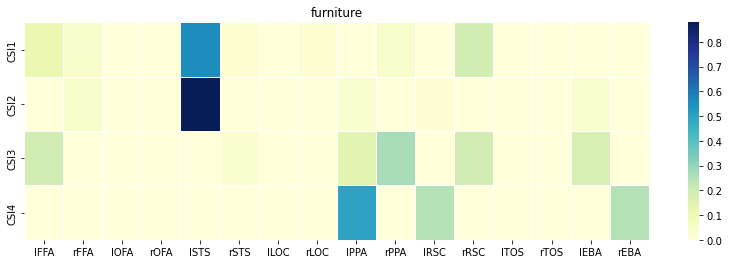

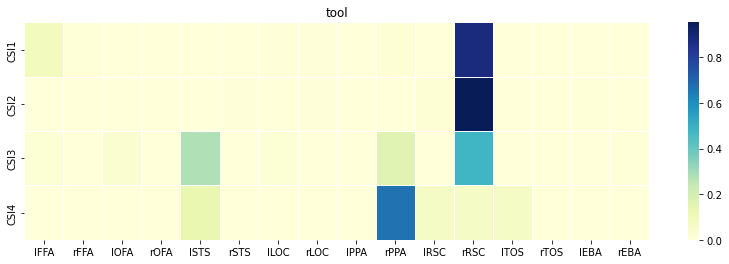

In [12]:
for i in range(len(names)):
    all_wts = np.array([all_wts0[i], all_wts1[i], all_wts2[i], all_wts3[i]])
    plt.rc('font', size=10)
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 4)
    ax = sns.heatmap(all_wts, linewidth=0.5, cmap="YlGnBu")
    ax.set_xticklabels(roi_names)
    ax.set_title(names[i])
    ax.set_yticklabels(subjs)
    plt.show()